# Global imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

# Qiskit
from qiskit import BasicAer
from qiskit.providers.aer import AerSimulator
from qiskit.circuit.library import ZZFeatureMap, PauliFeatureMap
from qiskit.utils import QuantumInstance, algorithm_globals
from qiskit_machine_learning.kernels import QuantumKernel
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit_machine_learning.datasets import ad_hoc_data

# Scikit
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn import metrics
from sklearn.svm import SVC
from collections import Counter

# Customized score functions
from qksvm.scores import get_scores, print_scores, print_cv_scores
# Custom visualization tools
from qksvm.visualization_tools import plot_dataset, plot_predictions, plot_decisions

from qksvm.QuantumFeatureMap import QuantumFeatureMap
from qksvm.QKSVM import QSVM_QKE

seed = 12345

# Qiskit Ad Hoc dataset

In [2]:
np.random.seed(seed=77)
algorithm_globals.random_seed = seed

# generate the dataset
adhoc_dimension = 2
X, y, _, _, adhoc_total = ad_hoc_data(
    training_size=200,
    test_size=2,
    n=adhoc_dimension,
    gap=0.2,
    plot_data=False,
    one_hot=False,
    include_sample_total=True
)
y = 2*y-1

print(f"Dataset statistics: {Counter(y)}")

Dataset statistics: Counter({-1: 200, 1: 200})


In [3]:
train_size = 50
test_size = 50
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    train_size=train_size, test_size=test_size,
    stratify=y, random_state=42,
)

print(f"Training target statistics: {Counter(y_train)}")
print(f"Testing target statistics: {Counter(y_test)}")

Training target statistics: Counter({1: 25, -1: 25})
Testing target statistics: Counter({-1: 25, 1: 25})


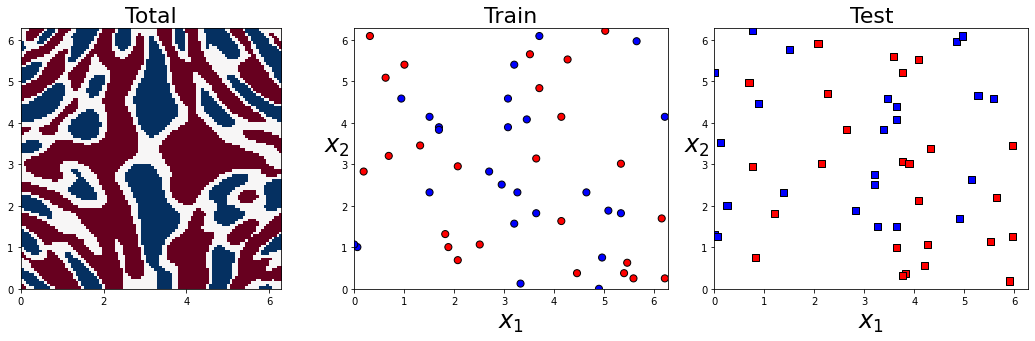

In [4]:
# Visualize the dataset
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

# visualize the dataset
xmin = 0; xmax = 2*np.pi
axes = [xmin, xmax, xmin, xmax]

ax1.set_title("Total", fontsize=22)
ax1.imshow(
    np.asmatrix(adhoc_total).T,
    interpolation="nearest",
    origin="lower",
    cmap=plt.cm.RdBu_r,
    extent=axes,
)

ax2.set_title("Train", fontsize=22)
plot_dataset(X_train, y_train, ax2, axes, marker='o', size=50, stepsize=1.0)
ax2.grid(False)

ax3.set_title("Test", fontsize=22)
plot_dataset(X_test, y_test, ax3, axes, marker='s', size=50, stepsize=1.0)
ax3.grid(False)

plt.rcParams['font.size'] = 15
plt.tight_layout()
plt.show()

## Visualize the classifier

In [61]:
def plot_results(clf, N=20):
    
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    axs[0].imshow(
        np.asmatrix(adhoc_total).T,
        interpolation="nearest",
        origin="lower",
        cmap=plt.cm.RdBu_r,
        extent=axes,
    )
    plot_predictions(clf, axs[1], axes, N=N)
    plot_dataset(X_test, y_test, axs[1], axes, stepsize=1.0)
    plot_decisions(clf, axs[2], axes, N=N)
    plot_dataset(X_test, y_test, axs[2], axes, stepsize=1.0)
    plt.tight_layout()
    plt.show()   

# RBF kernel

Best grid search parameters: {'C': 5, 'gamma': 1.0}
Best training score: 0.6858974358974359

Train set:
   Balanced accuracy:  0.96
                  F1:  0.96
             ROC_AUC:  1.00

Test set:
   Balanced accuracy:  0.72
                  F1:  0.73
             ROC_AUC:  0.73


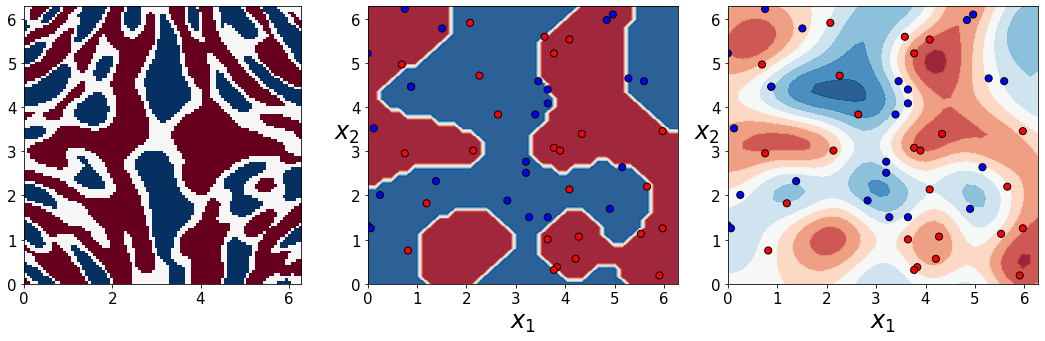

In [62]:
np.random.seed(seed)

param_grid = {
    "gamma": [0.001, 0.01, 0.1, 1.0, 5.0, 10.0],
    "C": [1, 5, 10, 20, 50, 100, 1000],
}

clf = GridSearchCV(
    estimator=SVC(kernel='rbf'),
    param_grid=param_grid,
    scoring='balanced_accuracy',
    n_jobs=1,
    refit=True,
    cv=StratifiedKFold(n_splits=2, shuffle=True, random_state=42),
)
clf.fit(X_train, y_train)

print('Best grid search parameters:', clf.best_params_)
print('Best training score:', clf.best_score_)

scores_ = get_scores(clf.best_estimator_, X_train, y_train)
print_scores(scores_, title='Train set:')

scores_ = get_scores(clf.best_estimator_, X_test, y_test)
print_scores(scores_, title='Test set:')

plot_results(clf.best_estimator_, N=40)

# QSVM 

## Qiskit ZZFeatureMap

     ┌───┐┌──────────────┐                                ┌───┐┌──────────────┐                                
q_0: ┤ H ├┤ Rz(2.0*x[0]) ├─■──────────────────────────────┤ H ├┤ Rz(2.0*x[0]) ├─■──────────────────────────────
     ├───┤├──────────────┤ │ZZ(2.0*(π - x[0])*(π - x[1])) ├───┤├──────────────┤ │ZZ(2.0*(π - x[0])*(π - x[1])) 
q_1: ┤ H ├┤ Rz(2.0*x[1]) ├─■──────────────────────────────┤ H ├┤ Rz(2.0*x[1]) ├─■──────────────────────────────
     └───┘└──────────────┘                                └───┘└──────────────┘                                

Train set:
   Balanced accuracy:  1.00
                  F1:  1.00
             ROC_AUC:  1.00

Test set:
   Balanced accuracy:  0.98
                  F1:  0.98
             ROC_AUC:  1.00


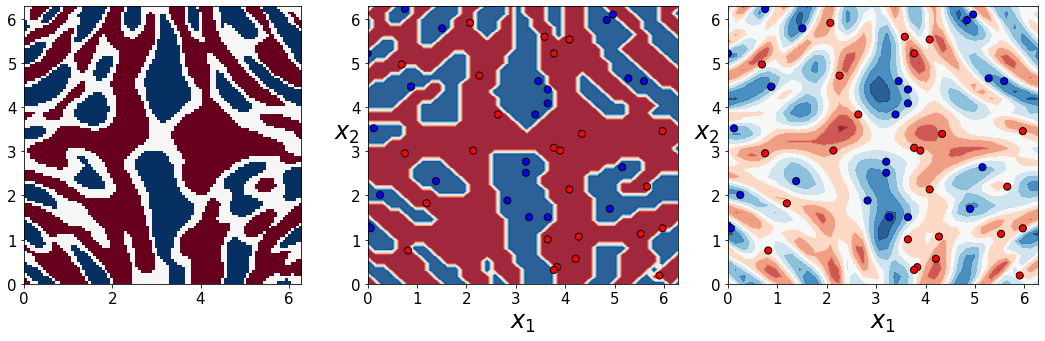

In [63]:
n_features = adhoc_dimension
n_qubits = 2
n_reps = 2

x = ParameterVector('x', length=n_qubits)
    
ansatz = QuantumCircuit(n_qubits)

j = 0
for r in range(n_reps):
    for i in range(n_qubits):
        ansatz.h(i)
        ansatz.rz(2.0*x[i%n_features], i)
        j += 1
    if n_qubits > 1:
        for i in range(n_qubits-1):
            a = 2.0 * (np.pi-x[i]) * (np.pi-x[i+1])
            ansatz.rzz(a, i, i+1)

print(ansatz.draw(plot_barriers=False, fold=120))

# backend = QuantumInstance(
#     BasicAer.get_backend("qasm_simulator"), shots=1024, seed_simulator=seed, seed_transpiler=seed
# )
backend = QuantumInstance(
            AerSimulator(method="statevector"),
            shots=1024, seed_simulator=seed, seed_transpiler=seed,
            backend_options = {'method': 'automatic', 
                               'max_parallel_threads': 0,
                               'max_parallel_experiments': 0,
                               'max_parallel_shots': 0},
        )
qkern = QuantumKernel(feature_map=ansatz, quantum_instance=backend)

qsvc = SVC(kernel=qkern.evaluate, C=1.0)
qsvc.fit(X_train, y_train)

scores_ = get_scores(qsvc, X_train, y_train)
print_scores(scores_, title='Train set:')

scores_ = get_scores(qsvc, X_test, y_test)
print_scores(scores_, title='Test set:')

plot_results(qsvc, N=40)

## H-RZ-CX 

     ┌───┐ ┌──────────────┐       ┌───┐ ┌──────────────┐       
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├───■───┤ H ├─┤ Rz(2.0*x[0]) ├───■───
     ├───┤ ├──────────────┤ ┌─┴─┐ ├───┤ ├──────────────┤ ┌─┴─┐ 
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├─┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├─
     └───┘ └──────────────┘ └───┘ └───┘ └──────────────┘ └───┘ 

Train scores:
   Balanced accuracy:  0.76
                  F1:  0.76
             ROC_AUC:  0.81

Test scores:
   Balanced accuracy:  0.76
                  F1:  0.73
             ROC_AUC:  0.81


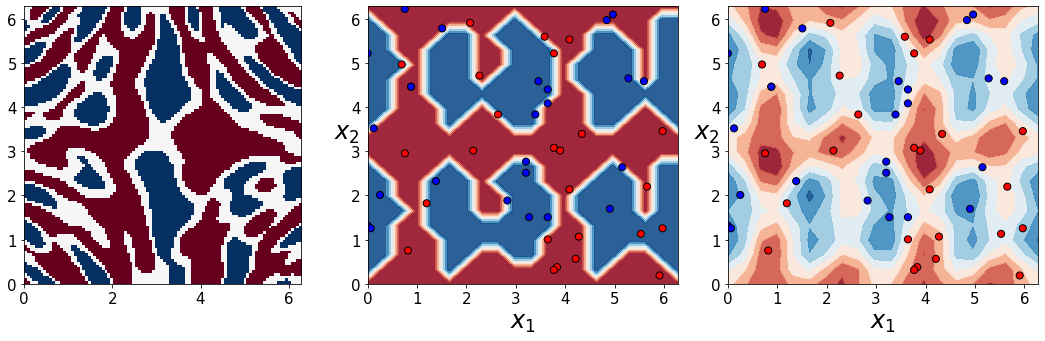

In [66]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['h', 'RZ', 'cx',], entanglement='linear',
    repeat=True,
    scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed, backend=backend)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌──────────────┐       ┌───┐ ┌──────────────┐       
q_0: ┤ H ├─┤ Rz(3.8*x[0]) ├───■───┤ H ├─┤ Rz(3.8*x[0]) ├───■───
     ├───┤ ├──────────────┤ ┌─┴─┐ ├───┤ ├──────────────┤ ┌─┴─┐ 
q_1: ┤ H ├─┤ Rz(3.8*x[1]) ├─┤ X ├─┤ H ├─┤ Rz(3.8*x[1]) ├─┤ X ├─
     └───┘ └──────────────┘ └───┘ └───┘ └──────────────┘ └───┘ 

Train scores:
   Balanced accuracy:  0.78
                  F1:  0.77
             ROC_AUC:  0.87

Test scores:
   Balanced accuracy:  0.78
                  F1:  0.73
             ROC_AUC:  0.85


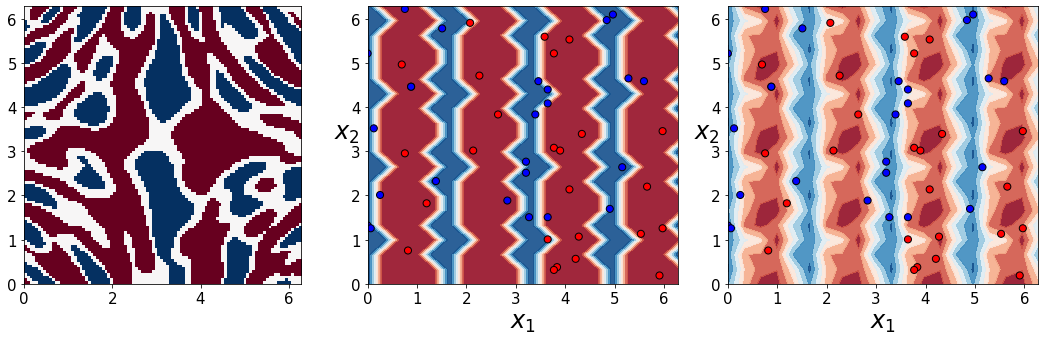

In [99]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['h', 'RZ', 'cx',], entanglement='linear',
    repeat=True,
    scale=False, alpha=3.8,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed, backend=backend)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)


	Encoding circuit is not specified. Is it what you are aiming at?

     ┌───┐             ┌──────────────┐                           ┌───┐ ┌───┐             ┌──────────────┐            »
q_0: ┤ H ├─────────────┤ Rz(2.0*x[0]) ├──────────────■────────────┤ X ├─┤ H ├─────────────┤ Rz(2.0*x[0]) ├────────────»
     ├───┤             ├──────────────┤            ┌─┴─┐          └─┬─┘ ├───┤             ├──────────────┤            »
q_1: ┤ H ├─────────────┤ Rz(2.0*x[1]) ├────────────┤ X ├──■─────────┼───┤ H ├─────────────┤ Rz(2.0*x[1]) ├────────────»
     ├───┤┌────────────┴──────────────┴───────────┐└───┘┌─┴─┐       │   ├───┤┌────────────┴──────────────┴───────────┐»
q_2: ┤ H ├┤ Rz(2.0*(π - 1.0*x[0])*(π - 1.0*x[1])) ├─────┤ X ├──■────┼───┤ H ├┤ Rz(2.0*(π - 1.0*x[0])*(π - 1.0*x[1])) ├»
     ├───┤├───────────────────────────────────────┤     └───┘┌─┴─┐  │   ├───┤├───────────────────────────────────────┤»
q_3: ┤ H ├┤ Rz(2.0*(π - 1.0*x[0])*(π - 1.0*x[1])) ├──────────┤ X ├──■───┤ H ├┤ Rz(2.0*(π - 1

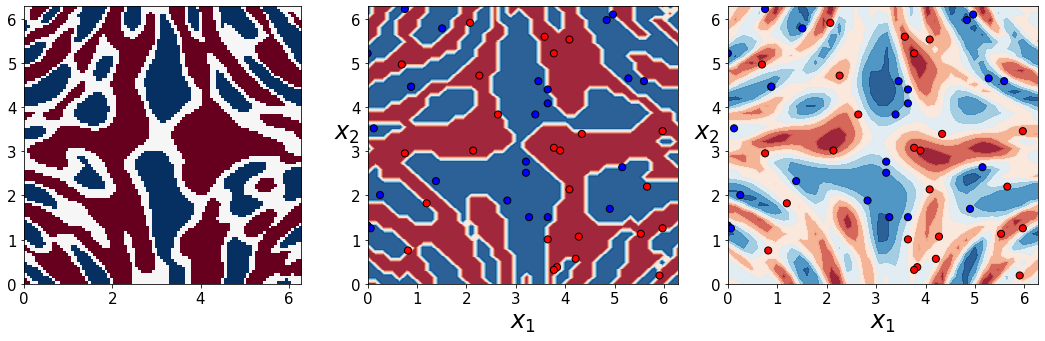

In [137]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=1,
    gates=[], entanglement='linear',
    repeat=True,
    scale=False, alpha=1.0,
)

for _ in range(2):
    
    for i in range(2):
        fm.h(i)
        fm.rz(2.0*fm.encod_params[i%fm.num_features], i)
        
    for i in range(2, fm.num_qubits):
        t = 2.0*(np.pi-fm.encod_params[i%fm.num_features])*(np.pi-fm.encod_params[(i+1)%fm.num_features])
        fm.h(i)
        fm.rz(t, i)
        
    for i in range(fm.num_qubits):
        fm.cx(i, (i+1)%fm.num_qubits)
    fm.barrier()
        
    # for i in range(fm.num_qubits):
    #     fm.cx(i, (i+1)%fm.num_qubits)
    # fm.barrier()

    # for i in range(fm.num_qubits):
    #     t = 2.0*(np.pi-fm.encod_params[i%fm.num_features])*(np.pi-fm.encod_params[(i+1)%fm.num_features])
    #     fm.crz(t, i, (i+1)%fm.num_qubits)
    
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed, backend=backend)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)


	Encoding circuit is not specified. Is it what you are aiming at?

     ┌───┐             ┌──────────────┐                      ┌───┐ ┌───┐             ┌──────────────┐                 »
q_0: ┤ H ├─────────────┤ Rz(2.0*x[0]) ├──────────────■───────┤ X ├─┤ H ├─────────────┤ Rz(2.0*x[0]) ├──────────────■──»
     ├───┤             ├──────────────┤            ┌─┴─┐     └─┬─┘ ├───┤             ├──────────────┤            ┌─┴─┐»
q_1: ┤ H ├─────────────┤ Rz(2.0*x[1]) ├────────────┤ X ├──■────┼───┤ H ├─────────────┤ Rz(2.0*x[1]) ├────────────┤ X ├»
     ├───┤┌────────────┴──────────────┴───────────┐└───┘┌─┴─┐  │   ├───┤┌────────────┴──────────────┴───────────┐└───┘»
q_2: ┤ H ├┤ Rz(2.0*(π - 1.0*x[0])*(π - 1.0*x[1])) ├─────┤ X ├──■───┤ H ├┤ Rz(2.0*(π - 1.0*x[0])*(π - 1.0*x[1])) ├─────»
     └───┘└───────────────────────────────────────┘     └───┘      └───┘└───────────────────────────────────────┘     »
«          ┌───┐ 
«q_0: ─────┤ X ├─
«          └─┬─┘ 
«q_1: ──■────┼───
«     ┌─┴─┐  │   
«q

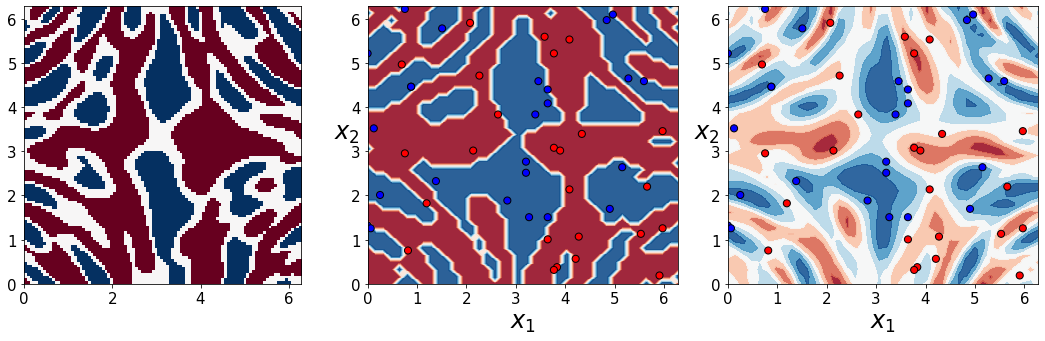

In [136]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=3,
    num_layers=1,
    gates=[], entanglement='linear',
    repeat=True,
    scale=False, alpha=1.0,
)

for _ in range(2):
    
    for i in range(2):
        fm.h(i)
        fm.rz(2.0*fm.encod_params[i%fm.num_features], i)
        
    for i in range(2, fm.num_qubits):
        t = 2.0*(np.pi-fm.encod_params[i%fm.num_features])*(np.pi-fm.encod_params[(i+1)%fm.num_features])
        fm.h(i)
        fm.rz(t, i)
        
    for i in range(fm.num_qubits):
        fm.cx(i, (i+1)%fm.num_qubits)
    fm.barrier()
        
    # for i in range(fm.num_qubits):
    #     fm.cx(i, (i+1)%fm.num_qubits)
    # fm.barrier()

    # for i in range(fm.num_qubits):
    #     t = 2.0*(np.pi-fm.encod_params[i%fm.num_features])*(np.pi-fm.encod_params[(i+1)%fm.num_features])
    #     fm.crz(t, i, (i+1)%fm.num_qubits)
    
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed, backend=backend)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=40)


	Encoding circuit is not specified. Is it what you are aiming at?

     ┌───┐┌──────────────┐                                         ┌───────────────────────────────────────┐┌───┐»
q_0: ┤ H ├┤ Rz(2.0*x[0]) ├────────────────────■────────────────────┤ Rz(2.0*(π - 1.0*x[0])*(π - 1.0*x[1])) ├┤ H ├»
     ├───┤├──────────────┤┌───────────────────┴───────────────────┐└───────────────────┬───────────────────┘├───┤»
q_1: ┤ H ├┤ Rz(2.0*x[1]) ├┤ Rz(2.0*(π - 1.0*x[0])*(π - 1.0*x[1])) ├────────────────────■────────────────────┤ H ├»
     └───┘└──────────────┘└───────────────────────────────────────┘                                         └───┘»
«     ┌──────────────┐                                         ┌───────────────────────────────────────┐
«q_0: ┤ Rz(2.0*x[0]) ├────────────────────■────────────────────┤ Rz(2.0*(π - 1.0*x[0])*(π - 1.0*x[1])) ├
«     ├──────────────┤┌───────────────────┴───────────────────┐└───────────────────┬───────────────────┘
«q_1: ┤ Rz(2.0*x[1]) ├┤ Rz(2.0*(π - 1.0*x[

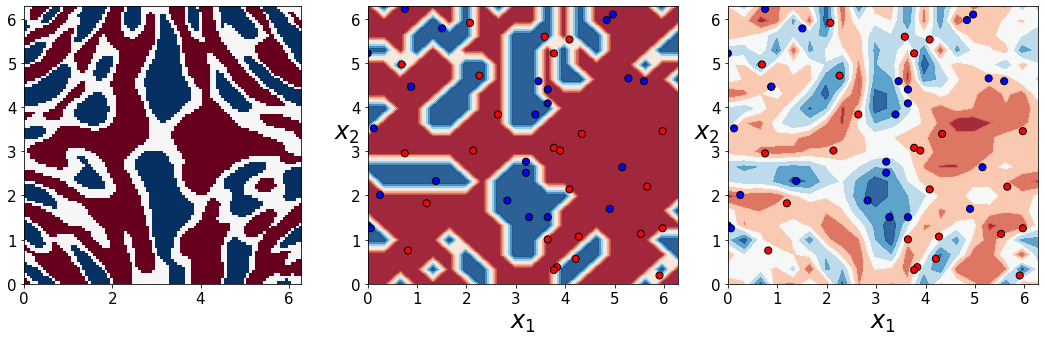

In [130]:
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=1,
    gates=[], entanglement='linear',
    repeat=True,
    scale=False, alpha=1.0,
)

for _ in range(2):
    for i in range(fm.num_qubits):
        fm.h(i)
        fm.rz(2.0*fm.encod_params[i%fm.num_features], i)
        
#     for i in range(fm.num_qubits):
#         fm.cx(i, (i+1)%fm.num_qubits)
#     fm.barrier()
        
#     for i in range(fm.num_qubits):
#         t = 2.0*(np.pi-fm.encod_params[i%fm.num_features])*(np.pi-fm.encod_params[(i+1)%fm.num_features])
#         fm.rz(t, i)
        
    # for i in range(fm.num_qubits):
    #     fm.cx(i, (i+1)%fm.num_qubits)
    # fm.barrier()

    for i in range(fm.num_qubits):
        t = 2.0*(np.pi-fm.encod_params[i%fm.num_features])*(np.pi-fm.encod_params[(i+1)%fm.num_features])
        fm.crz(t, i, (i+1)%fm.num_qubits)
    
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed, backend=backend)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌──────────────┐            ┌───┐ ┌──────────────┐            
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├───■────────┤ H ├─┤ Rz(2.0*x[0]) ├───■────────
     ├───┤ ├──────────────┤ ┌─┴─┐      ├───┤ ├──────────────┤ ┌─┴─┐      
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───
     ├───┤ ├──────────────┤ └───┘┌─┴─┐ ├───┤ ├──────────────┤ └───┘┌─┴─┐ 
q_2: ┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─
     ├───┤ ├──────────────┤ ┌─┴─┐└───┘ ├───┤ ├──────────────┤ ┌─┴─┐└───┘ 
q_3: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──────┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──────
     └───┘ └──────────────┘ └───┘      └───┘ └──────────────┘ └───┘      

Train scores:
   Balanced accuracy:  0.82
                  F1:  0.81
             ROC_AUC:  0.90

Test scores:
   Balanced accuracy:  0.74
                  F1:  0.70
             ROC_AUC:  0.86


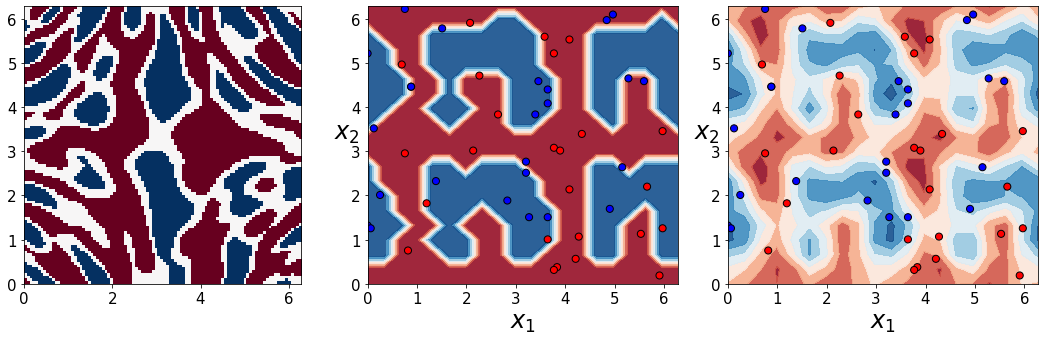

In [86]:
## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=2,
    # gates=['h', 'RZ', 'cx', ], entanglement='linear',
    repeat=True,
    scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed, backend=backend)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌──────────────┐                                 ┌──────────────┐ ┌───┐ ┌──────────────┐                 »
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├────────■────────────────────────┤ Rx(2.0*x[1]) ├─┤ H ├─┤ Rz(2.0*x[0]) ├────────■────────»
     ├───┤ ├──────────────┤ ┌──────┴───────┐                └──────┬───────┘ ├───┤ ├──────────────┤ ┌──────┴───────┐»
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Rx(2.0*x[0]) ├───────■───────────────┼─────────┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Rx(2.0*x[0]) ├»
     ├───┤ ├──────────────┤ └──────────────┘┌──────┴───────┐       │         ├───┤ ├──────────────┤ └──────────────┘»
q_2: ┤ H ├─┤ Rz(2.0*x[0]) ├────────■────────┤ Rx(2.0*x[0]) ├───────┼─────────┤ H ├─┤ Rz(2.0*x[0]) ├────────■────────»
     ├───┤ ├──────────────┤ ┌──────┴───────┐└──────────────┘       │         ├───┤ ├──────────────┤ ┌──────┴───────┐»
q_3: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Rx(2.0*x[1]) ├───────────────────────■─────────┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Rx(2.0*x[1]) ├»
     └───┘ └──────────────┘ └──────────────┘            

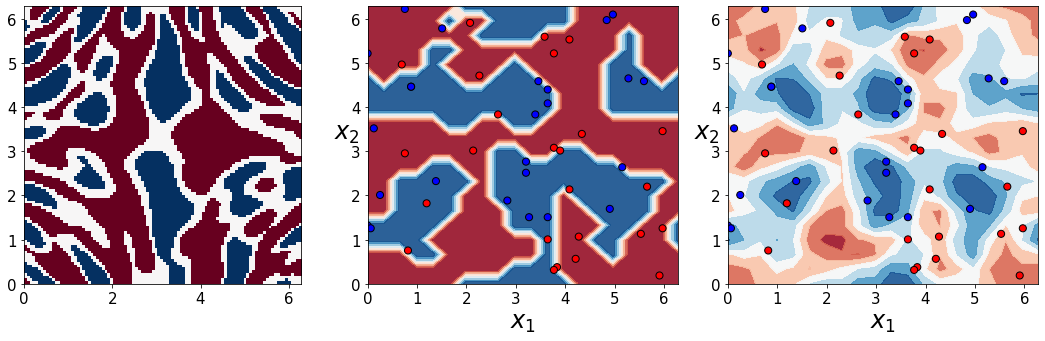

In [24]:
## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=2,
    gates=['h', 'RZ', 'CRX',], entanglement='ring',
    repeat=True,
    scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed, backend=backend)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

     ┌───┐ ┌──────────────┐                                                                                           »
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├──■──────────────■──────────────■──────────────■───────────────────────────────────────────»
     ├───┤ ├──────────────┤  │ZZ(2.0*x[0])  │              │              │ZZ(2.0*x[1])                               »
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├──■──────────────┼──────────────┼──────────────■──────────────■──────────────■─────────────»
     ├───┤ ├──────────────┤                 │ZZ(2.0*x[1])  │                             │ZZ(2.0*x[0])  │             »
q_2: ┤ H ├─┤ Rz(2.0*x[0]) ├─────────────────■──────────────┼─────────────────────────────■──────────────┼─────────────»
     ├───┤ ├──────────────┤                                │ZZ(2.0*x[0])                                │ZZ(2.0*x[1]) »
q_3: ┤ H ├─┤ Rz(2.0*x[1]) ├────────────────────────────────■────────────────────────────────────────────■─────────────»
     └───┘ └──────────────┘             

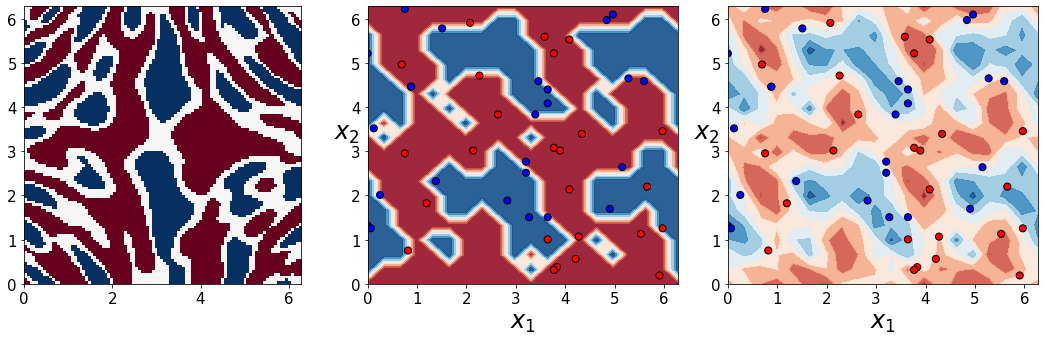

In [95]:
## Specify Feature Map
fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=1,
    gates=['h', 'RZ', 'RZZ', ], entanglement='full',
    repeat=True,
    scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

qsvc = QSVM_QKE(fm, X_train, y_train, seed=seed, backend=backend)

train_scores = get_scores(qsvc, X_train, y_train)
print_scores(train_scores, title='Train scores:')

test_scores  = get_scores(qsvc, X_test,  y_test)
print_scores(test_scores, title='Test scores:')

plot_results(qsvc, N=20)

## Model cross-validation

In [72]:
np.random.seed(seed)

fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=2,
    num_layers=2,
    gates=['h', 'RZ', 'cx',], entanglement='linear',
    repeat=True,
    scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10

n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
cv = StratifiedShuffleSplit(
    n_splits=n_splits, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

i = 0
for train, test in cv.split(X, y):
    i += 1
    print(f"Train/Test CV Subset {i}")
    
    qsvc = QSVM_QKE(fm, X[train,:], y[train], seed=seed, backend=backend)
   
    train_scores = get_scores(qsvc, X[train,:], y[train])
    test_scores = get_scores(qsvc, X[test,:], y[test])
    scores_tr.append(train_scores)
    scores_tt.append(test_scores)
    if test_scores[scoring] > best_score:
        best_score = test_scores[scoring]
        best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

     ┌───┐ ┌──────────────┐       ┌───┐ ┌──────────────┐       
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├───■───┤ H ├─┤ Rz(2.0*x[0]) ├───■───
     ├───┤ ├──────────────┤ ┌─┴─┐ ├───┤ ├──────────────┤ ┌─┴─┐ 
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├─┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├─
     └───┘ └──────────────┘ └───┘ └───┘ └──────────────┘ └───┘ 
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  0.76

Train set:
   Balanced accuracy:  0.78 +- 0.06
                  F1:  0.76 +- 0.09
             ROC_AUC:  0.86 +- 0.05

Test set:
   Balanced accuracy:  0.68 +- 0.06
                  F1:  0.65 +- 0.07
             ROC_AUC:  0.77 +- 0.06


In [96]:
np.random.seed(seed)

fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=2,
    gates=['h', 'RZ', 'cx',], entanglement='linear',
    repeat=True,
    scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10

n_splits = 5
# cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=100)
cv = StratifiedShuffleSplit(
    n_splits=n_splits, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

i = 0
for train, test in cv.split(X, y):
    i += 1
    print(f"Train/Test CV Subset {i}")
    
    qsvc = QSVM_QKE(fm, X[train,:], y[train], seed=seed, backend=backend)
   
    train_scores = get_scores(qsvc, X[train,:], y[train])
    test_scores = get_scores(qsvc, X[test,:], y[test])
    scores_tr.append(train_scores)
    scores_tt.append(test_scores)
    if test_scores[scoring] > best_score:
        best_score = test_scores[scoring]
        best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

     ┌───┐ ┌──────────────┐            ┌───┐ ┌──────────────┐            
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├───■────────┤ H ├─┤ Rz(2.0*x[0]) ├───■────────
     ├───┤ ├──────────────┤ ┌─┴─┐      ├───┤ ├──────────────┤ ┌─┴─┐      
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──■───
     ├───┤ ├──────────────┤ └───┘┌─┴─┐ ├───┤ ├──────────────┤ └───┘┌─┴─┐ 
q_2: ┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─┤ H ├─┤ Rz(2.0*x[0]) ├───■──┤ X ├─
     ├───┤ ├──────────────┤ ┌─┴─┐└───┘ ├───┤ ├──────────────┤ ┌─┴─┐└───┘ 
q_3: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──────┤ H ├─┤ Rz(2.0*x[1]) ├─┤ X ├──────
     └───┘ └──────────────┘ └───┘      └───┘ └──────────────┘ └───┘      
Train/Test CV Subset 1
Train/Test CV Subset 2
Train/Test CV Subset 3
Train/Test CV Subset 4
Train/Test CV Subset 5

==== Cross-Validation Scores ====

Best train score:  0.72

Train set:
   Balanced accuracy:  0.83 +- 0.07
                  F1:  0.83 +- 0.08
             ROC_AUC:  0.92 +- 0.04

Test set:
   Balanced accuracy:  0.67 

In [98]:
np.random.seed(seed)

fm = QuantumFeatureMap(
    num_features=len(X[0]), 
    num_qubits=4,
    num_layers=2,
    gates=['h', 'RZ', 'CRX',], entanglement='linear',
    repeat=True,
    scale=False, alpha=2.0,
)
print(fm.draw(plot_barriers=False, fold=120))

scoring = 0 # 0=acc, 1=f1, 2=roc
best_score = 0.0
scores_tr = []
scores_tt = []

# train_size = 10
# test_size = 10

n_splits = 5
cv = StratifiedShuffleSplit(
    n_splits=n_splits, 
    train_size=train_size, test_size=test_size, 
    random_state=seed
)

i = 0
for train, test in cv.split(X, y):
    i += 1
    print(f"Train/Test CV Subset {i}")
    
    qsvc = QSVM_QKE(fm, X[train,:], y[train], seed=seed, backend=backend)
   
    train_scores = get_scores(qsvc, X[train,:], y[train])
    test_scores = get_scores(qsvc, X[test,:], y[test])
    scores_tr.append(train_scores)
    scores_tt.append(test_scores)
    if test_scores[scoring] > best_score:
        best_score = test_scores[scoring]
        best_qsvc = qsvc

print('')
print('==== Cross-Validation Scores ====')
print("\nBest train score: ", best_score)
print_cv_scores(scores_tr, title='Train set:')
print_cv_scores(scores_tt, title='Test set:')

     ┌───┐ ┌──────────────┐                                  ┌───┐ ┌──────────────┐                                  
q_0: ┤ H ├─┤ Rz(2.0*x[0]) ├────────■─────────────────────────┤ H ├─┤ Rz(2.0*x[1]) ├────────■─────────────────────────
     ├───┤ ├──────────────┤ ┌──────┴───────┐                 ├───┤ ├──────────────┤ ┌──────┴───────┐                 
q_1: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Rx(2.0*x[0]) ├───────■─────────┤ H ├─┤ Rz(2.0*x[0]) ├─┤ Rx(2.0*x[1]) ├───────■─────────
     ├───┤ ├──────────────┤ └──────────────┘┌──────┴───────┐ ├───┤ ├──────────────┤ └──────────────┘┌──────┴───────┐ 
q_2: ┤ H ├─┤ Rz(2.0*x[0]) ├────────■────────┤ Rx(2.0*x[0]) ├─┤ H ├─┤ Rz(2.0*x[1]) ├────────■────────┤ Rx(2.0*x[1]) ├─
     ├───┤ ├──────────────┤ ┌──────┴───────┐└──────────────┘ ├───┤ ├──────────────┤ ┌──────┴───────┐└──────────────┘ 
q_3: ┤ H ├─┤ Rz(2.0*x[1]) ├─┤ Rx(2.0*x[1]) ├─────────────────┤ H ├─┤ Rz(2.0*x[0]) ├─┤ Rx(2.0*x[0]) ├─────────────────
     └───┘ └──────────────┘ └──────────────┘            